In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob


def calibrate_camera(images, nx=9, ny=6):             
    objpoints = []  # 3D points in real world space
    imgpoints = []  # 2D points in image plane
    
    # Prepare object points, like (0,0,0), (1,0,0), ..., (nx,ny,0)
    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)  # x, y coordinates
    
    for img_path in images:
        img = cv2.imread(img_path)
    
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
            
        if ret:
            imgpoints.append(corners)
            objpoints.append(objp)
            # cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            # plt.imshow(img)
        else:
            # TODO: why some images have no corners found???
            print('WARN: no corners was found for image: %s!!!' % img_path)
    
    return objpoints, imgpoints
    
    
def undistort_image(img, objpoints, imgpoints):    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undistorted_image = cv2.undistort(img, mtx, dist, None, mtx)
    return undistorted_image

WARN: no corners was found for image: camera_cal/calibration5.jpg!!!
WARN: no corners was found for image: camera_cal/calibration4.jpg!!!
WARN: no corners was found for image: camera_cal/calibration1.jpg!!!


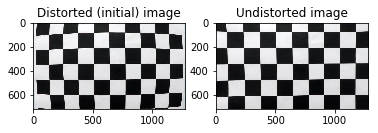

In [2]:
images = glob.glob('camera_cal/calibration*.jpg')
objpoints, imgpoints = calibrate_camera(images)

distorted_img = cv2.imread(images[6])
undistorted_img = undistort_image(distorted_img, objpoints, imgpoints)

fig, axs = plt.subplots(1, 2)
plt.rcParams['figure.figsize'] = 15, 15
subplot = axs[0]
subplot.set_title('Distorted (initial) image')
subplot.imshow(distorted_img)

subplot = axs[1]
subplot.set_title('Undistorted image')
subplot.imshow(undistorted_img)

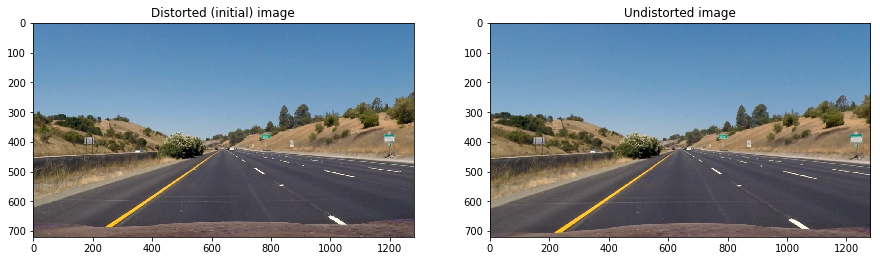

In [3]:
distorted_test_img = mpimg.imread('test_images/straight_lines1.jpg')
undistorted_test_img = undistort_image(distorted_test_img, objpoints, imgpoints)

fig, axs = plt.subplots(1, 2)
plt.rcParams['figure.figsize'] = 15, 15
subplot = axs[0]
subplot.set_title('Distorted (initial) image')
subplot.imshow(distorted_test_img)

subplot = axs[1]
subplot.set_title('Undistorted image')
subplot.imshow(undistorted_test_img)

In [4]:
def perspective_transform(img):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
def create_vertices(img):
    imshape = img.shape
    return np.array([[ 
        (.440*imshape[1], .65*imshape[0]), 
        (.200*imshape[1], .93*imshape[0]), 
        (.820*imshape[1], .93*imshape[0]),
        (.563*imshape[1], .65*imshape[0])]], dtype=np.int32)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def print_vertice(image, ver1, ver2):
    cv2.line(image, (int(ver1[0]), int(ver1[1])), (int(ver2[0]), int(ver2[1])), [255, 0, 0], 2)
    
def show_region_of_interest(image, vertices):
    print_vertice(image, vertices[0][0], vertices[0][1])
    print_vertice(image, vertices[0][1], vertices[0][2])
    print_vertice(image, vertices[0][2], vertices[0][3])
    print_vertice(image, vertices[0][3], vertices[0][0])

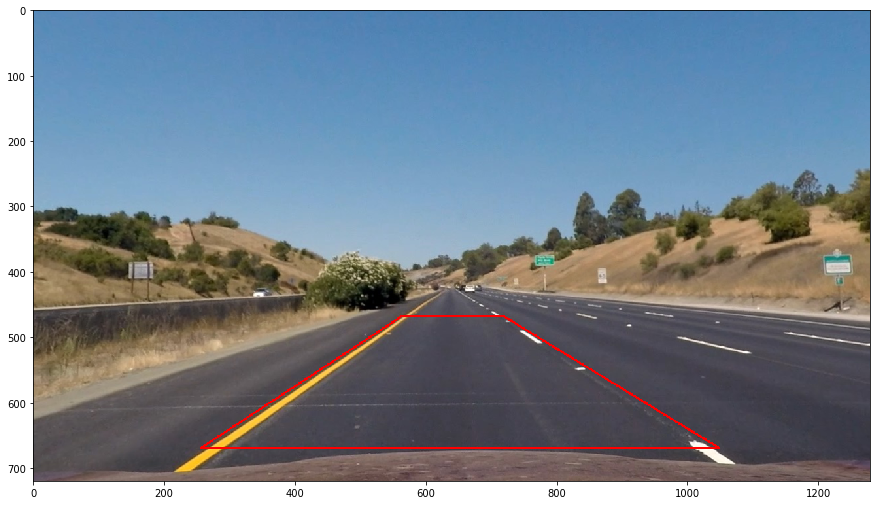

In [5]:
vertices = create_vertices(undistorted_test_img)
#masked_edges = region_of_interest(edges_img, vertices)
show_region_of_interest(undistorted_test_img, vertices)
plt.imshow(undistorted_test_img)

In [6]:
points = vertices[0]
src = np.float32(points)
print("src coordinates: \n", src)

dest = np.float32(
     [[points[1][0], 200],
      points[1],
      points[2],
     [points[2][0], 200]]
)
print("dest coordinates: \n", dest)

src coordinates: 
 [[  563.   468.]
 [  256.   669.]
 [ 1049.   669.]
 [  720.   468.]]
dest coordinates: 
 [[  256.   200.]
 [  256.   669.]
 [ 1049.   669.]
 [ 1049.   200.]]


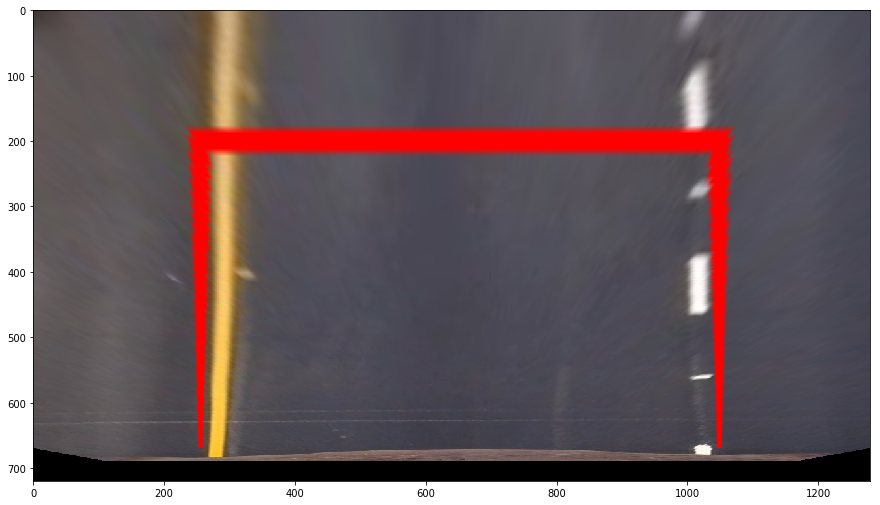

In [7]:
M = cv2.getPerspectiveTransform(src, dest)
img_size = (undistorted_test_img.shape[1], undistorted_test_img.shape[0])
warped = cv2.warpPerspective(undistorted_test_img, M, img_size, flags=cv2.INTER_LINEAR)
plt.imshow(warped)

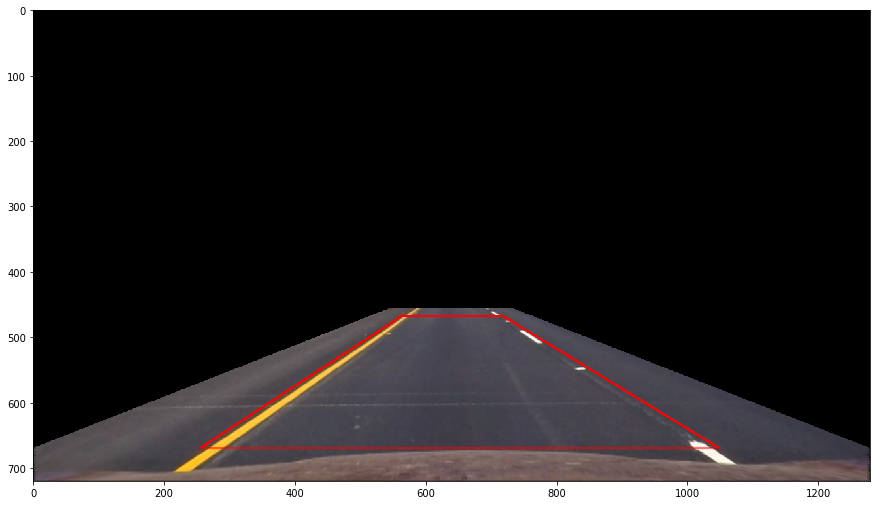

In [8]:
Minv = cv2.getPerspectiveTransform(dest, src)
unwarped = cv2.warpPerspective(warped, Minv, img_size, flags=cv2.INTER_LINEAR)
plt.imshow(unwarped)

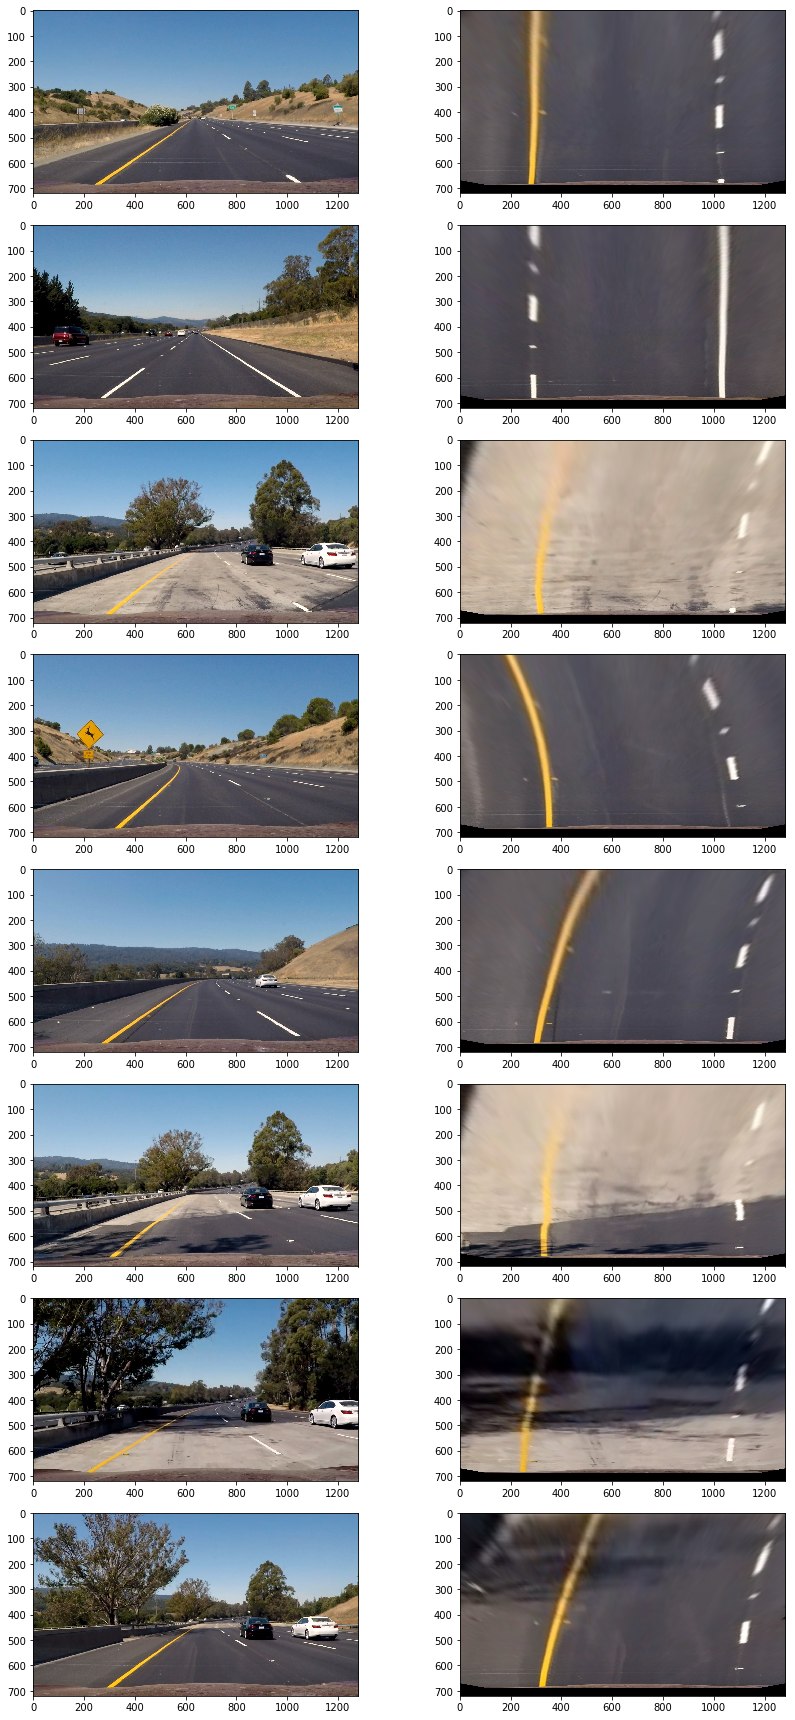

In [9]:
# Test on all test images
list_of_images = ['straight_lines1.jpg', 'straight_lines2.jpg', 'test1.jpg', 'test2.jpg', 'test3.jpg', 
                  'test4.jpg', 'test5.jpg', 'test6.jpg']

columns = 2
rows = len(list_of_images)

fig, axs = plt.subplots(rows, columns, figsize=(12, 24))
fig.tight_layout()

for index, img_name in enumerate(list_of_images):
    orig_img = mpimg.imread('test_images/' + img_name)
    axs[index, 0].imshow(orig_img)
    
    undistorted_img = undistort_image(orig_img, objpoints, imgpoints)
    warped_img = cv2.warpPerspective(undistorted_img, M, img_size, flags=cv2.INTER_LINEAR)
    axs[index, 1].imshow(warped_img)

In [10]:
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary

def binary_warped(orig_img, objpoints, imgpoints, M):
    undistorted_img = undistort_image(orig_img, objpoints, imgpoints)
    img_size = (orig_img.shape[1], orig_img.shape[0])
    warped_img = cv2.warpPerspective(undistorted_img, M, img_size, flags=cv2.INTER_LINEAR)
    binary_warped_img = pipeline(warped_img)
    return binary_warped_img

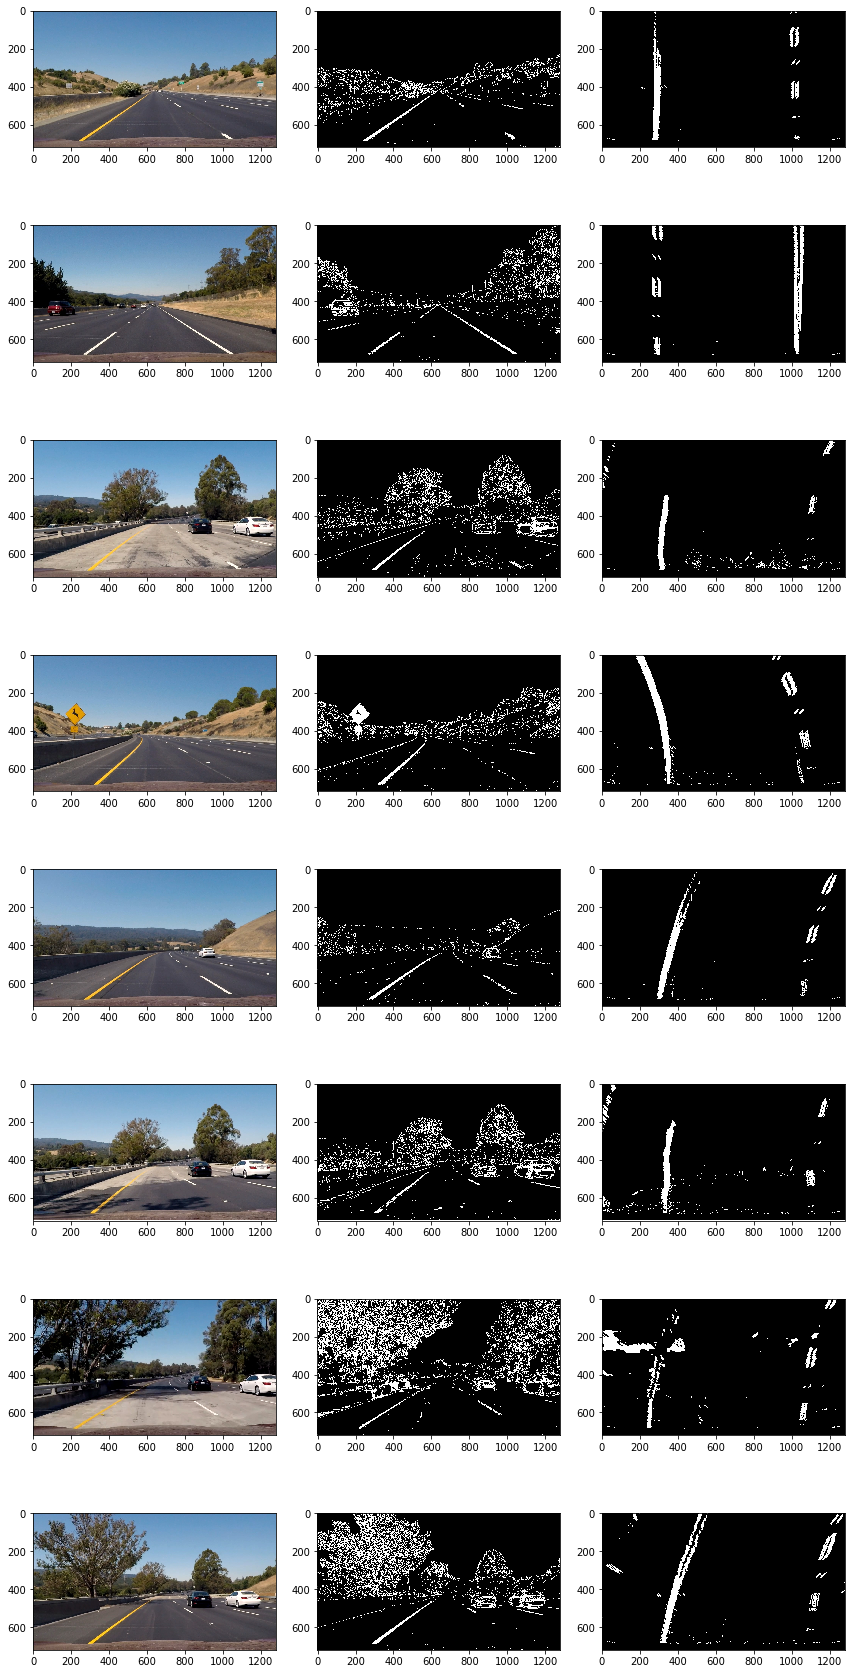

In [11]:
fig, axs = plt.subplots(rows, 3, figsize=(12, 24))
fig.tight_layout()

for index, img_name in enumerate(list_of_images):
    orig_img = mpimg.imread('test_images/' + img_name)
    axs[index, 0].imshow(orig_img)
    
    result_img = pipeline(orig_img)
    axs[index, 1].imshow(result_img, cmap='gray')
    
    warped_pipe_img = binary_warped(orig_img, objpoints, imgpoints, M)
    axs[index, 2].imshow(warped_pipe_img, cmap='gray')


## 5. Finding lines

In [12]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None 

In [13]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0) 
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty


def fit_polynomial(binary_warped, left_line, right_line):
    # Find our lane pixels first
    left_line.allx, left_line.ally, right_line.allx, right_line.ally = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_line.best_fit = np.polyfit(left_line.ally, left_line.allx, 2)
    right_line.best_fit = np.polyfit(right_line.ally, right_line.allx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_line.recent_xfitted = left_line.best_fit[0]*ploty**2 + left_line.best_fit[1]*ploty + left_line.best_fit[2]
    right_line.recent_xfitted = right_line.best_fit[0]*ploty**2 + right_line.best_fit[1]*ploty + right_line.best_fit[2]
    
    right_line.detected = True    
    left_line.detected = True
    
    return left_line, right_line, ploty

In [14]:
def visualize_sliding_windows(binary_warped_img, left_line, right_line):
    out_img = np.dstack((binary_warped_img, binary_warped_img, binary_warped_img))
    
    # TODO: visualize sliding windows
    # Draw the windows on the visualization image
    #cv2.rectangle(binary_warped_img,(win_xleft_low,win_y_low),
    #(win_xleft_high,win_y_high),(0,255,0), 2) 
    #cv2.rectangle(binary_warped_img,(win_xright_low,win_y_low),
    #(win_xright_high,win_y_high),(0,255,0), 2) 
    
    out_img[left_line.ally, left_line.allx] = [255, 0, 0]
    out_img[right_line.ally, right_line.allx] = [0, 0, 255]
    
    plt.plot(left_line.recent_xfitted, ploty, color='yellow')
    plt.plot(right_line.recent_xfitted, ploty, color='yellow')
    
    plt.imshow(out_img)

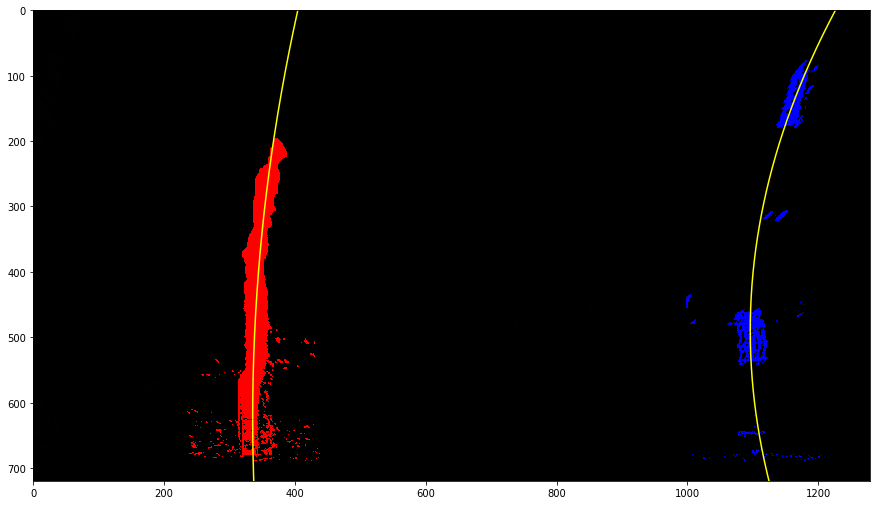

In [15]:
import timeit

# Load our image and visualize sliding windows with fit line
t1 = timeit.timeit()
orig_img = mpimg.imread('test_images/test4.jpg')
t2 = timeit.timeit()

binary_warped_img = binary_warped(orig_img, objpoints, imgpoints, M)
t3 = timeit.timeit()

left_line = Line()
right_line = Line()
left_line, right_line, ploty = fit_polynomial(binary_warped_img, left_line, right_line)
t4 = timeit.timeit()
visualize_sliding_windows(binary_warped_img, left_line, right_line)

In [16]:
## SEARCH FROM PRIOR
def fit_poly(img_shape, left_line, right_line):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_line.best_fit = np.polyfit(left_line.ally, left_line.allx, 2)
    right_line.best_fit = np.polyfit(right_line.ally, right_line.allx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### Calc both polynomials using ploty, left_fit and right_fit ###
    # TODO: move to Line class 
    left_line.recent_xfitted = left_line.best_fit[0]*ploty**2 + left_line.best_fit[1]*ploty + left_line.best_fit[2]
    right_line.recent_xfitted = right_line.best_fit[0]*ploty**2 + right_line.best_fit[1]*ploty + right_line.best_fit[2]
    
    return ploty

def search_around_poly(binary_warped, left_line, right_line):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 20

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_line.best_fit[0]*(nonzeroy**2) + left_line.best_fit[1]*nonzeroy + 
                    left_line.best_fit[2] - margin)) & (nonzerox < (left_line.best_fit[0]*(nonzeroy**2) + 
                    left_line.best_fit[1]*nonzeroy + left_line.best_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_line.best_fit[0]*(nonzeroy**2) + right_line.best_fit[1]*nonzeroy + 
                    right_line.best_fit[2] - margin)) & (nonzerox < (right_line.best_fit[0]*(nonzeroy**2) + 
                    right_line.best_fit[1]*nonzeroy + right_line.best_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    left_line.allx = nonzerox[left_lane_inds]
    left_line.ally = nonzeroy[left_lane_inds] 
    right_line.allx = nonzerox[right_lane_inds]
    right_line.ally = nonzeroy[right_lane_inds]

    # Fit new polynomials
    ploty = fit_poly(binary_warped.shape, left_line, right_line)
    
    return ploty

In [17]:
def visualize_search_around(binary_warped_img, left_line, right_line):
    # Duplicated for visualizing purposes
    margin = 20
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped_img, binary_warped_img, binary_warped_img))*255
    window_img = np.zeros_like(out_img)
    
    # Grab activated pixels
    nonzero = binary_warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Color in left and right line pixels
    out_img[left_line.ally, left_line.allx] = [255, 0, 0]
    out_img[right_line.ally, right_line.allx] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_line.recent_xfitted-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_line.recent_xfitted+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_line.recent_xfitted-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_line.recent_xfitted+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_line.recent_xfitted, ploty, color='yellow')
    plt.plot(right_line.recent_xfitted, ploty, color='yellow')
    
    plt.imshow(result)

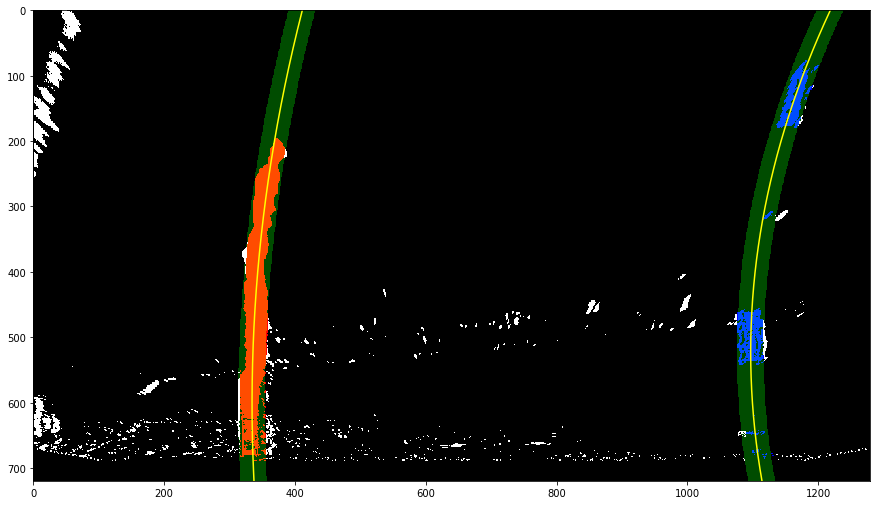

In [18]:
ploty = search_around_poly(binary_warped_img, left_line, right_line)
visualize_search_around(binary_warped_img, left_line, right_line)

## Draw

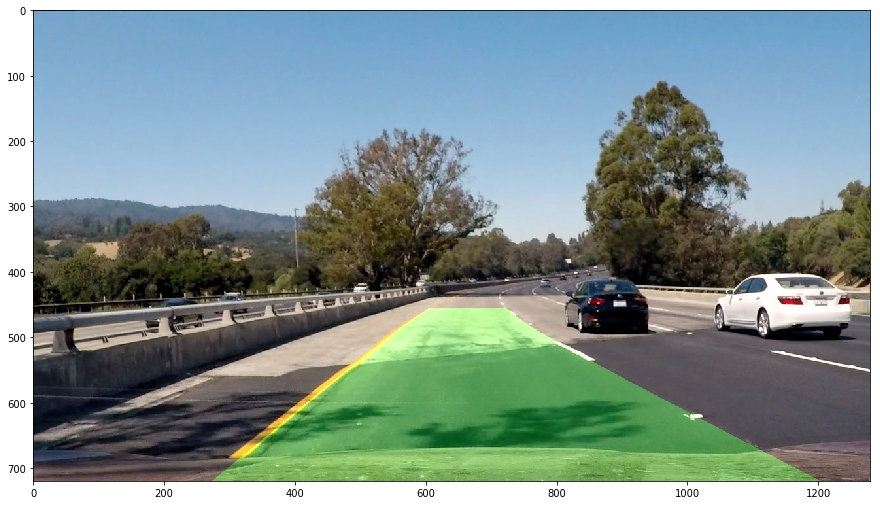

In [19]:
def draw_lines(orig_img, binary_warped_img, left_fitx, right_fitx, ploty): 

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (orig_img.shape[1], orig_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(orig_img, 1, newwarp, 0.3, 0)
    return result

img_with_lines = draw_lines(orig_img, binary_warped_img, left_line.recent_xfitted, right_line.recent_xfitted, ploty)
plt.imshow(img_with_lines)

## Video

In [20]:
import time

class LaneFinder():
    def __init__(self):
        self.right_line = Line()
        self.left_line = Line()
    
    def process_image(self, orig_img):
        t1 = time.time()
        #undistorted_img = undistort_image(orig_img, objpoints, imgpoints)
        undistorted_img = orig_img
        t2 = time.time()
        warped_img = cv2.warpPerspective(undistorted_img, M, img_size, flags=cv2.INTER_LINEAR)
        t3 = time.time()
        binary_warped_img = pipeline(warped_img)

        t4 = time.time()
        if self.left_line.detected == True and self.right_line.detected == True:
            ploty = search_around_poly(binary_warped_img, self.left_line, self.right_line)
        else:
            self.left_line, self.right_line, ploty = fit_polynomial(binary_warped_img, self.left_line, self.right_line)

        t5 = time.time()
            
        img_with_lines = draw_lines(orig_img, binary_warped_img, self.left_line.recent_xfitted, self.right_line.recent_xfitted, ploty)
        t6 = time.time()
        
        #print('undistort_image: ', t2-t1)
        #print('warpPerspective: ', t3-t2)
        #print('pipeline: ', t4-t3)
        #print('fit: ', t5-t4)
        #print('draw_lines: ', t6-t5)
        #print('total: ', t6-t1)
        return img_with_lines
    
    def process_frame_callback(self):
        return lambda img: self.process_image(img)

In [21]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [22]:
inputVideoClip = VideoFileClip('project_video.mp4')
outputVideoName = 'project_video_output.mp4'

laneFinder = LaneFinder()
outputVideoClip = inputVideoClip.fl_image(laneFinder.process_frame_callback())
%time outputVideoClip.write_videofile(outputVideoName, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [01:51<00:00, 11.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 6min 56s, sys: 43.5 s, total: 7min 40s
Wall time: 1min 51s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(outputVideoName))

In [24]:
inputChallengeVideoClip = VideoFileClip('challenge_video.mp4')
outputChallengeVideoName = 'challenge_video_output.mp4'

laneFinder = LaneFinder()
outputChallengeVideoClip = inputChallengeVideoClip.fl_image(laneFinder.process_frame_callback())
%time outputChallengeVideoClip.write_videofile(outputChallengeVideoName, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████| 485/485 [00:35<00:00, 13.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 2min 14s, sys: 12.3 s, total: 2min 26s
Wall time: 36.5 s


In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(outputChallengeVideoName))

In [ ]:
inputHarderVideoClip = VideoFileClip('harder_challenge_video.mp4')
outputHarderVideoName = 'harder_challenge_video_output.mp4'

laneFinder = LaneFinder()
outputHarderVideoClip = inputHarderVideoClip.fl_image(laneFinder.process_frame_callback())
%time outputHarderVideoClip.write_videofile(outputHarderVideoName, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


 88%|████████▊ | 1059/1200 [01:33<00:12, 11.31it/s]